In [380]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

In [381]:
data = pd.read_csv('202310-divvy-tripdata.csv')
data = data[pd.to_numeric(data['start_station_id'], errors='coerce').notnull()]
data = data[pd.to_numeric(data['end_station_id'], errors='coerce').notnull()]
data = data.dropna(subset=['start_station_id', 'end_station_id'])

In [382]:

start = pd.DataFrame(data['start_station_id'].value_counts())
end = pd.DataFrame(data['end_station_id'].value_counts())
start = start.rename(columns={'count': 'startcount'})
start.head()

,startcount
start_station_id,
13022,2230
13300,1883
13216,1310
15544,1284
13008,1258


In [383]:
end = end.rename(columns={'count': 'endcount'})
end.head()

,endcount
end_station_id,
13022,2546
13300,1703
13008,1403
13216,1305
13042,1289


In [384]:
stations = pd.concat([start['startcount'], end['endcount']], axis=1)
stations['total'] = stations['startcount'] + stations['endcount']
stations.head(10)
#stations['total'] = stations['start_station_id'] + stations['end_station_id']
#stations.head(10)

,startcount,endcount,total
13022,2230.0,2546.0,4776.0
13300,1883.0,1703.0,3586.0
13216,1310.0,1305.0,2615.0
15544,1284.0,1114.0,2398.0
13008,1258.0,1403.0,2661.0
13042,1150.0,1289.0,2439.0
13217,1092.0,1067.0,2159.0
13011,1004.0,943.0,1947.0
638,988.0,1047.0,2035.0
13061,965.0,964.0,1929.0


In [385]:
stats = stations.sort_values('total', ascending=False).head(10)
stats = list(stats.index)
print(stats)

['13022', '13300', '13008', '13216', '13042', '15544', '13217', '638', '13011', '13061']


In [386]:
# take out just these top stations from the data
divd = data[(data['start_station_id'].isin(stats)) | (data['end_station_id'].isin(stats))]
divd.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
603,A1B0885683D4B4CC,classic_bike,2023-10-13 18:31:25,2023-10-13 18:54:00,Streeter Dr & Grand Ave,13022,Larrabee St & Webster Ave,13193,41.892278,-87.612043,41.921822,-87.644140,member
608,8BECFAB67F1FA81D,classic_bike,2023-10-22 17:44:50,2023-10-22 18:09:05,Streeter Dr & Grand Ave,13022,Larrabee St & Webster Ave,13193,41.892278,-87.612043,41.921822,-87.644140,casual
1042,BE2395919F04F1E0,electric_bike,2023-10-28 15:56:13,2023-10-28 16:15:34,Streeter Dr & Grand Ave,13022,Aberdeen St & Randolph St,18062,41.892319,-87.612234,41.884114,-87.654264,member
1198,8527F766D559425F,electric_bike,2023-10-28 15:55:45,2023-10-28 16:15:36,Streeter Dr & Grand Ave,13022,Aberdeen St & Randolph St,18062,41.892313,-87.612226,41.884114,-87.654264,member
1200,A4A3170B63E200BB,electric_bike,2023-10-23 18:26:25,2023-10-23 18:41:07,Streeter Dr & Grand Ave,13022,Larrabee St & Webster Ave,13193,41.892294,-87.612193,41.921822,-87.644140,member


In [387]:
print(divd.columns)

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual'],
      dtype='object')


In [388]:
# don't need ride_id, rideable_type, start_lat, start_lng, end_lat, end_lng, or member_casual
divd = divd[['started_at', 'ended_at', 'start_station_name', 'start_station_id', 'end_station_name', 'end_station_id']]
divd.head()

,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id
603,2023-10-13 18:31:25,2023-10-13 18:54:00,Streeter Dr & Grand Ave,13022,Larrabee St & Webster Ave,13193
608,2023-10-22 17:44:50,2023-10-22 18:09:05,Streeter Dr & Grand Ave,13022,Larrabee St & Webster Ave,13193
1042,2023-10-28 15:56:13,2023-10-28 16:15:34,Streeter Dr & Grand Ave,13022,Aberdeen St & Randolph St,18062
1198,2023-10-28 15:55:45,2023-10-28 16:15:36,Streeter Dr & Grand Ave,13022,Aberdeen St & Randolph St,18062
1200,2023-10-23 18:26:25,2023-10-23 18:41:07,Streeter Dr & Grand Ave,13022,Larrabee St & Webster Ave,13193


In [389]:
# need to change started_at to month day and time
divd['started_at'] = pd.to_datetime(divd['started_at'])

divd['day'] = divd['started_at'].dt.day_name()

divd['month'] = divd['started_at'].dt.month_name()

divd['hours'] = divd['started_at'].map(lambda x: str(x)[11:13])
divd['hour'] = divd['hours']

divd.drop('started_at', axis=1, inplace=True)
divd.drop('ended_at', axis=1, inplace=True)
divd.head()

,start_station_name,start_station_id,end_station_name,end_station_id,day,month,hours,hour
603,Streeter Dr & Grand Ave,13022,Larrabee St & Webster Ave,13193,Friday,October,18,18
608,Streeter Dr & Grand Ave,13022,Larrabee St & Webster Ave,13193,Sunday,October,17,17
1042,Streeter Dr & Grand Ave,13022,Aberdeen St & Randolph St,18062,Saturday,October,15,15
1198,Streeter Dr & Grand Ave,13022,Aberdeen St & Randolph St,18062,Saturday,October,15,15
1200,Streeter Dr & Grand Ave,13022,Larrabee St & Webster Ave,13193,Monday,October,18,18


In [390]:
#divd['hour'] = divd['hours']
# group by starting station and the hour
divd = pd.DataFrame(divd.groupby(['start_station_name', 'hours'])['hour'].count())
divd = divd.rename(columns={'hour':'count'})
divd = divd.reset_index()
print(divd.columns)
divd.head()

Index(['start_station_name', 'hours', 'count'], dtype='object')


,start_station_name,hours,count
0,63rd St Beach,10,2
1,900 W Harrison St,05,1
2,900 W Harrison St,06,1
3,900 W Harrison St,08,2
4,900 W Harrison St,09,1


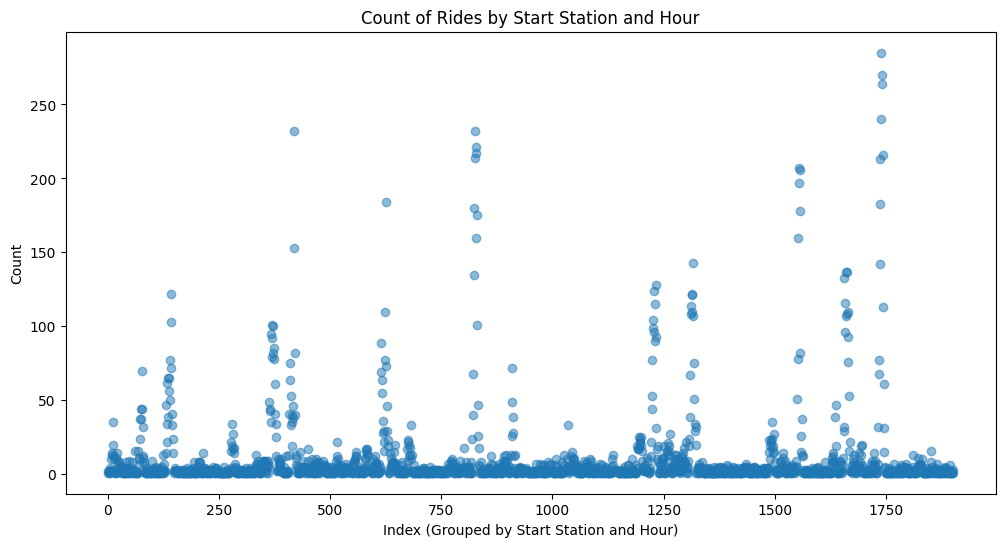

In [391]:
import matplotlib.pyplot as plt

# Assuming you have already run the groupby and reset_index operations
# divd = pd.DataFrame(divd.groupby(['start_station_name', 'hours'])['hour'].count())
# divd = divd.rename(columns={'hour':'count'})
# divd = divd.reset_index()

# Plotting the target column
plt.figure(figsize=(12, 6))
plt.scatter(divd.index, divd['count'], alpha=0.5)
plt.title('Count of Rides by Start Station and Hour')
plt.xlabel('Index (Grouped by Start Station and Hour)')
plt.ylabel('Count')
plt.show()

In [403]:
from sklearn.model_selection import train_test_split
# split into train and test data using sklearn.model_selection
features = ['start_station_name', 'hours']
X = pd.get_dummies(divd[features], columns=['start_station_name'], drop_first=True)
y = divd['count']
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)
xtrain = xtrain.to_numpy()
print("Training set shapes: xtrain: ", xtrain.shape, " ytrain: ", ytrain.shape)
print("Testing set shapes: xtest: ", xtest.shape, "ytest", ytest.shape)
weights = np.random.normal(0, 1, xtrain.shape[1])
bias = np.random.normal(0, 1, 1)
print(weights)
print(bias)

Training set shapes: xtrain:  (1522, 232)  ytrain:  (1522,)
Testing set shapes: xtest:  (381, 232) ytest (381,)
[ 0.67752667 -0.9845288  -0.32691231 -0.57612934  0.41944847 -0.84943309
  1.11676662  0.91404887  0.07774415  0.16434683 -0.17322457 -1.00429093
  0.35331368  1.10175395 -0.67383502 -1.10583387  0.79707298 -0.60746213
 -0.71340577 -1.6623414   0.17162618  0.20720282  1.83727746 -0.0972785
  0.81995015 -0.6780608  -0.57091521  1.49306737 -0.44433742  0.46316869
  0.72463088  0.25198952  0.06309524  0.85204088  0.02578473 -0.74148048
 -1.38465531  0.91804606 -0.96253851 -1.74144922 -0.59898322  1.55800744
  0.23111145 -0.10716649 -0.34988486 -0.800337    0.05599103  1.55081907
  1.40108173 -1.03714846  0.400987    0.13426102 -1.31850349  1.2916157
  0.79934549  1.25898661  0.49309374 -0.4897943   1.44911885  0.93844827
  1.1904415  -1.29419732 -0.19843935  0.74369445 -0.47104313  0.18758308
 -0.99000328  0.269115    1.40112074 -0.68585385  0.08612142 -0.80836107
  1.14448484  

In [404]:
# Create a Decision Tree Regressor
tree_model = DecisionTreeRegressor(random_state=42)

In [405]:
# Train the model
tree_model.fit(xtrain, ytrain)

DecisionTreeRegressor(random_state=42)

In [406]:
# Predict on the test set
y_pred = tree_model.predict(xtest)

/Users/neelu/clear/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


In [407]:
# Evaluate the model
mse = mean_squared_error(ytest, y_pred)
r2 = r2_score(ytest, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 80.85826771653544
R-squared: 0.7999080844623294


In [408]:
# Cross-validation
cv_scores = cross_val_score(tree_model, X, y, cv=5)
print(f'Cross-validation Scores: {cv_scores}')

Cross-validation Scores: [-0.18578454 -0.13012444 -0.06895957 -0.16735423 -0.11044304]


In [409]:
# Feature importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': tree_model.feature_importances_})
feature_importances = feature_importances.sort_values('Importance', ascending=False)
print('Feature Importances:')
print(feature_importances.head())

Feature Importances:
                                               Feature  Importance
0                                                hours    0.483260
207         start_station_name_Streeter Dr & Grand Ave    0.177193
99   start_station_name_DuSable Lake Shore Dr & Mon...    0.093948
185                  start_station_name_Shedd Aquarium    0.060209
200              start_station_name_State St & 33rd St    0.032891


In [410]:
# Set a threshold to classify as high or low
threshold = 5  # You can adjust this threshold based on your problem

# Convert regression predictions to binary classification
y_pred_class = (y_pred > threshold).astype(int)
ytest_class = (ytest > threshold).astype(int)

# Calculate accuracy
accuracy = np.mean(y_pred_class == ytest_class)

print(f'Accuracy: {accuracy}')

Accuracy: 0.8136482939632546


In [411]:
# the sigmoid function
def sigmoid(v):
    return np.exp(-np.logaddexp(0, -v))
# the prob function with the sigmoid function
def prob(x, w, b):
    print(x.shape)
    print(w.shape)
    return sigmoid(np.dot(x, w) + b)
np.linalg.norm(weights)

15.004694856138762

In [412]:
# cross entropy loss
def loss(w, x, y_prob, y_true, lambda_):
    dnum = x.shape[0]
    first = -1/dnum

    sum = np.sum(y_true * np.log(y_prob+1e-15) + (1-y_true)*np.log(1-y_prob+1e-15))
    eq = first*sum
    ww = np.sum(w**2)
    last = lambda_/2 * ww
    loss = eq + last
    return loss

In [413]:
# gradients with respect to weights and bias
# returns tuple
def grad_w_b(x, w, y_prob, y_true, lambda_):
    last = lambda_ * w
    grad_w = np.dot(x.T, (y_prob-y_true).reshape(-1, 1)) + last
    grad_b = np.sum(y_prob-y_true)
    return (grad_w, grad_b)

In [414]:
# fit function for linear regression model
def fit(x, y_true, lr, lamb, max_iter, verbose=0):
    w = np.random.normal(0, 1, x.shape[1])
    b = np.random.normal(0, 1)
    for i in range(max_iter):
        y_prob = prob(x, w, b)
        gw, gb = grad_w_b(x, w, y_prob, y_true, lamb)
        w = w - lr*gw
        b = b - lr*gb
        if verbose:
            l = loss(w, x, y_prob, y_true, lamb)
            gradnormw = np.linalg.norm(gw)
            weightnorm = np.linalg.norm(w)
            print(f"Iteration {i}")
            print(f"Loss: {l}")
            print(f"l2 norm of gradients: {gradnormw}")
            print(f"l2 norm of weigts: {weightnorm}")
    return (w, b)
# accuracy function
def accuracy(x, y_true, model):
    w, b = model
    return np.sum((prob(x, w, b)>0.5).astype(np.float) == y_true) / y_true.shape[0]

In [415]:
lr = 0.001
lamb = 1.0

model = fit(xtrain, ytrain, lr, lamb, 10000, verbose=1)

(1522, 232)
(232,)


TypeError: can't multiply sequence by non-int of type 'float'